## Common Imports and downloading a datasets

Downloading datasets:
* cats vs dogs


In [0]:
%load_ext tensorboard

In [2]:
%tensorflow_version 2.x
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import datetime
from tensorflow.keras.preprocessing import image
from zipfile import ZipFile 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TensorFlow 2.x selected.


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!rm -rf sample_data

In [0]:
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!echo '{"username":"USERNAME","key":"API_KEY"}' > /root/.kaggle/kaggle.json

In [7]:
!kaggle datasets download "chetankv/dogs-cats-images"

 98% 426M/435M [00:13<00:00, 38.6MB/s]
100% 435M/435M [00:13<00:00, 33.6MB/s]


In [0]:
!unzip -q dogs-cats-images.zip

## Reading dogs vs cats ds 

In [0]:
test_dir="dog vs cat/dataset/test_set"
train_dir="dog vs cat/dataset/training_set"

train_dir_cats = train_dir + '/cats'
train_dir_dogs = train_dir + '/dogs'
test_dir_cats = test_dir + '/cats'
test_dir_dogs = test_dir + '/dogs'

In [0]:
import pathlib
DATA_DIR = "dog vs cat/dataset/"
train_dir = pathlib.Path(DATA_DIR + "training_set")
test_dir = pathlib.Path(DATA_DIR + "test_set")

In [11]:
train_image_count = len(list(train_dir.glob('*/*.jpg')))
test_image_count = len(list(test_dir.glob('*/*.jpg')))
(train_image_count, test_image_count)

(8000, 2000)

In [12]:
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['dogs', 'cats'], dtype='<U4')

In [0]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 25

In [0]:
data_generator = ImageDataGenerator(rescale = 1.0/255.0, zoom_range = 0.2)

In [0]:
def list_files(data_dir):
  return tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [19]:
AUTOTUNE = 100

def load_cats_vs_dogs():
  train_list_ds = list_files(train_dir)
  test_list_ds = list_files(test_dir)

  for f in train_list_ds.take(5):
    print(f.numpy())
  # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
  return (
      train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE),
      test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE),
  )

train_labeled_ds, test_labeled_ds = load_cats_vs_dogs()

b'dog vs cat/dataset/training_set/dogs/dog.3521.jpg'
b'dog vs cat/dataset/training_set/dogs/dog.2157.jpg'
b'dog vs cat/dataset/training_set/cats/cat.1529.jpg'
b'dog vs cat/dataset/training_set/cats/cat.2065.jpg'
b'dog vs cat/dataset/training_set/cats/cat.1998.jpg'


In [20]:
for image, label in train_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())


Image shape:  (224, 224, 3)
Label:  [False  True]


In [0]:
def prepare_for_training(ds, batch_size=BATCH_SIZE, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(batch_size)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(train_labeled_ds)
test_ds = prepare_for_training(test_labeled_ds)

image_batch, label_batch = next(iter(train_ds))

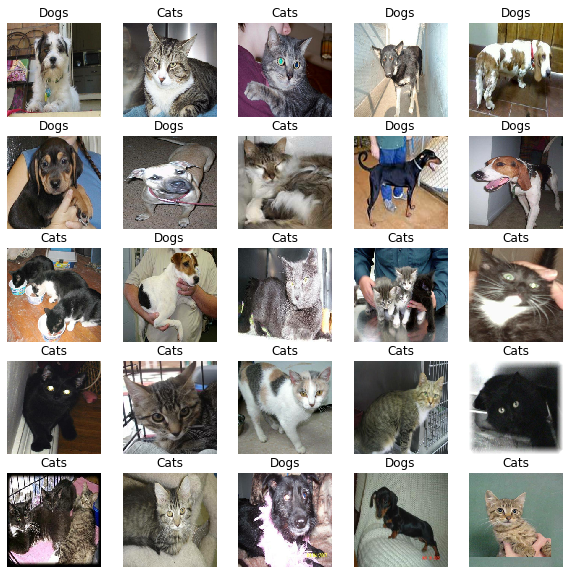

In [23]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

show_batch(image_batch.numpy(), label_batch.numpy())

In [24]:
label_batch.numpy()

array([[ True, False],
       [False,  True],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True, False],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [ True, False],
       [ True, False],
       [False,  True]])

## TF for local runs


In [0]:
def allow_memory_growth():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
# run the line below if you're using local runtime and have GTX > 1660 (this is known bug with tensorflow memory allocation)
# allow_memory_growth()

## Model definition

In [0]:
import tensorflow.keras.layers as layers
from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet50

In [0]:
class AttensionALPModel(tf.keras.Model):

  def __init__(self, num_classes, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)):
    super(AttensionALPModel, self).__init__(name="attension_alp_model")
    self.num_classes = num_classes
    self.res_net = ResNet50(include_top=False, input_shape=input_shape)
    self.classifier = Sequential()
    self.classifier.add(layers.Flatten())
    self.classifier.add(layers.Dense(1024, activation="relu"))
    self.classifier.add(layers.BatchNormalization())
    self.classifier.add(layers.Dense(200, activation='relu'))
    self.classifier.add(layers.BatchNormalization())
    self.classifier.add(layers.Dense(num_classes, activation='softmax'))

    for layer in self.res_net.layers:
      layer.trainable = False

  def call(self, inputs):
    resnet_features = self.res_net(inputs)
    return self.classifier(resnet_features)

def train_step_attension_alp_model(attension_alp_model, 
                                   optim,
                                   loss_f,
                                   train_loss,
                                   train_accuracy):
  @tf.function
  def _train_step_attension_alp_model(images, labels):
    with tf.GradientTape() as tape:
      gen_out = attension_alp_model(images)      
      loss = loss_f(labels, gen_out)
    
    grads = tape.gradient(loss, attension_alp_model.classifier.trainable_variables)
    optim.apply_gradients(zip(grads, attension_alp_model.classifier.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, gen_out)
  return _train_step_attension_alp_model

def validation_step_attension_alp_model(attension_alp_model, 
                                        loss_f,
                                        validation_loss,
                                        validation_accuracy):
  @tf.function
  def _validation_step_attension_alp_model(images, labels):
    gen_out = attension_alp_model(images)      
    loss = loss_f(labels, gen_out)

    validation_loss(loss)
    validation_accuracy(labels, gen_out)

  return _validation_step_attension_alp_model

In [0]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
validation_log_dir = 'logs/gradient_tape/' + current_time + '/validation'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
validation_summary_writer = tf.summary.create_file_writer(validation_log_dir)


In [0]:
def train(train_step, 
          validation_step, 
          train_ds, 
          validation_ds,
          epochs,
          train_steps_per_epoch,
          validation_steps_per_epoch
          ):
  for epoch in range(epochs):
    
    for i, (images, labels) in enumerate(train_ds):
      train_step(images, labels)
      if i == train_steps_per_epoch:
        break

    with train_summary_writer.as_default():
      tf.summary.scalar("loss", train_loss.result(), step=epoch)
      tf.summary.scalar("accuracy", train_accuracy.result(), step=epoch)

    for i, (images, labels) in enumerate(validation_ds):
      validation_step(images, labels)
      if i == validation_steps_per_epoch:
        break

    with validation_summary_writer.as_default():
      tf.summary.scalar("loss", validation_loss.result(), step=epoch)
      tf.summary.scalar("accuracy", validation_accuracy.result(), step=epoch)


    template = 'Epoch {}, Loss: {}, Accuracy: {} , Validation Loss: {}, Validation Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(), 
                          train_accuracy.result(),
                          validation_loss.result(), 
                          validation_accuracy.result()))

    train_loss.reset_states()
    train_accuracy.reset_states()
    validation_loss.reset_states()
    validation_accuracy.reset_states()



## Train Model

In [30]:
attension_alp_model = AttensionALPModel(2)
optim = tf.optimizers.Nadam()

train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.CategoricalAccuracy('train_accuracy')
validation_loss = tf.keras.metrics.Mean('validation_loss', dtype=tf.float32)
validation_accuracy = tf.keras.metrics.CategoricalAccuracy('validation_accuracy')

train_step = train_step_attension_alp_model(
    attension_alp_model=attension_alp_model,
    optim=optim,
    loss_f=tf.keras.losses.categorical_crossentropy,
    train_loss=train_loss,
    train_accuracy=train_accuracy)

validation_step = validation_step_attension_alp_model(
    attension_alp_model,
    loss_f=tf.keras.losses.categorical_crossentropy,
    validation_loss=validation_loss,
    validation_accuracy=validation_accuracy
)

94773248/94765736 [==============================] - 7s 0us/step


In [31]:
%tensorboard --logdir logs/gradient_tape

In [32]:
train(train_step, 
      validation_step,
      train_ds,
      test_ds,
      10,
      train_steps_per_epoch=train_image_count / BATCH_SIZE,
      validation_steps_per_epoch=test_image_count / BATCH_SIZE)

Epoch 1, Loss: 1.5757803916931152, Accuracy: 0.5510280132293701 , Validation Loss: 0.6543044447898865, Validation Accuracy: 0.6355555653572083
Epoch 2, Loss: 0.6848022937774658, Accuracy: 0.6105918884277344 , Validation Loss: 0.6578929424285889, Validation Accuracy: 0.6024691462516785
Epoch 3, Loss: 0.6272553205490112, Accuracy: 0.646105945110321 , Validation Loss: 0.632258415222168, Validation Accuracy: 0.6419752836227417
Epoch 4, Loss: 0.6144010424613953, Accuracy: 0.6570716500282288 , Validation Loss: 0.6189765930175781, Validation Accuracy: 0.6720987558364868
Epoch 5, Loss: 0.5999723076820374, Accuracy: 0.6776323914527893 , Validation Loss: 0.6308556795120239, Validation Accuracy: 0.6696296334266663
Epoch 6, Loss: 0.5872856378555298, Accuracy: 0.6838629245758057 , Validation Loss: 0.6231396794319153, Validation Accuracy: 0.6804938316345215
Epoch 7, Loss: 0.5761978030204773, Accuracy: 0.701433002948761 , Validation Loss: 0.5941383242607117, Validation Accuracy: 0.7081481218338013
Ep

In [33]:
import tensorflow.keras.metrics as metrics

attension_alp_model.summary()

Model: "attension_alp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
sequential (Sequential)      multiple                  102971770 
Total params: 126,559,482
Trainable params: 102,969,322
Non-trainable params: 23,590,160
_________________________________________________________________


## FGSM model

In [0]:
class AdversarialPaternFinder(object):
  def __init__(self, model):
    self.model = model

  def create_adversarial_pattern(self, input_image, input_label, **kwargs):
    raise NotImplementedError

  def apply_adversarial_pattern(self, pattern, input_image, **kwargs):
    raise NotImplementedError

  def generate_adversarial_example(self, input_image, input_label, 
                                   create_args, apply_args):
    pattern = self.create_adversarial_pattern(input_image, input_label, 
                                               **create_args)
    return self.apply_adversarial_pattern(pattern, input_image, **apply_args)

class FGSM(AdversarialPaternFinder):
  def create_adversarial_pattern(self, input_image, input_label, **kwargs):
    loss_object = kwargs.get('loss_object', tf.keras.losses.CategoricalCrossentropy())
    
    with tf.GradientTape() as tape:
      tape.watch(input_image)
      prediction = self.model(input_image)
      loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

  def apply_adversarial_pattern(self, pattern, input_image, **kwargs):
    epsilon = kwargs.get("epsilon", 0.01)
    return input_image + epsilon * pattern



## Generate Adversarial Examples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

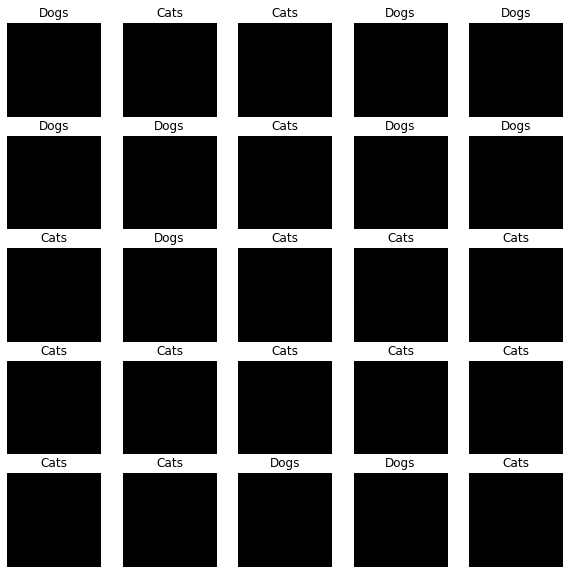

In [106]:
adv_examples = []

paternFinder = FGSM(attension_alp_model)

for image, label in zip(image_batch, label_batch):
  perturbations = paternFinder.generate_adversarial_example(image[None,:,:,:], label, {'loss_object': tf.keras.losses.CategoricalCrossentropy()}, {'epsilon': 0.05})
  adv_examples.append(perturbations[0].numpy())

show_batch(adv_examples, label_batch.numpy())
